In [1]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse


/vol/bitbucket/mh1022/dl_cw_pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse

def boolean_string(s):
    if s not in {'False', 'True'}:
        raise ValueError('Not a valid boolean string')
    return s == 'True'

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# device
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')
print(device)

### for debugging use cpu
#device = cpu

config = {
#    "run_name": "Run_test_TLWAN"
    "run_name": "viz"
    ,"project_path": '/vol/bitbucket/mh1022/temporal-modelling-icd'
    ,"base_checkpoint": os.path.join("", "RoBERTa-base-PM-M3-Voc-hf")
    ,"num_attention_heads": 1
    ,"num_layers": 1
    ,"lr": 5e-5
    ,"max_chunks": 4
    ,"grad_accumulation": 4
    ,"use_positional_embeddings": True
    ,"use_reverse_positional_embeddings": True
    ,"priority_mode": "None"
    ,"priority_idxs": [1]
    ,"use_document_embeddings": True
    ,"use_reverse_document_embeddings": True
    ,"use_category_embeddings": True
    ,"num_labels": 50
    ,"use_all_tokens": True
    ,"num_heads_labattn":1
    ,"final_aggregation": "cls"
    ,"only_discharge_summary": False
    ,"patience_threshold": 3
    ,"max_epochs": 3
    ,"save_model": False
    ,"load_from_checkpoint": False
    ,"checkpoint_name": "Run_all_notes_last_second_transf"
    ,"evaluate_temporal": False
    ,"use_multihead_attention": False
    ,"debug": False
}
with open(os.path.join("", f"results/config_{config['run_name']}.json"), "w") as f:
    json.dump(config, f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)
notes_agg_df, categories_mapping = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])

# Get training / validation / test
dataset_config = {
    "max_chunks" : config["max_chunks"],
    "priority_mode" : config["priority_mode"],
    "priority_idxs" : config["priority_idxs"]
}
training_set = get_dataset(notes_agg_df, "TRAIN", tokenizer = tokenizer, **dataset_config)
training_generator = get_dataloader(training_set)

validation_set =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)
validation_generator = get_dataloader(validation_set)

test_set = get_dataset(notes_agg_df, "TEST", tokenizer = tokenizer, **dataset_config)
test_generator = get_dataloader(test_set)


cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Analyze length of DS (if we take only last 4 chunks, how much do we miss?)

In [13]:
# Get number of chunks in each time frame
from tqdm import tqdm
hours_elapsed_list = []
categories_list = []
seq_ids_list = []
for i in tqdm(range(len(validation_set))):

    input_ids = training_set[i]["input_ids"]
    attention_mask = training_set[i]["attention_mask"]
    seq_ids = training_set[i]["seq_ids"]
    category_ids = training_set[i]["category_ids"]
    hours_elapsed = training_set[i]["hours_elapsed"]
    cutoffs = training_set[i]["cutoffs"]
    hours_elapsed_list.append(hours_elapsed.tolist())
    categories_list.append(category_ids.tolist())
    seq_ids_list.append(seq_ids.tolist())


100%|██████████| 1573/1573 [08:02<00:00,  3.26it/s]


Text(0.5, 1.0, 'Distribution of chunks in hours elapsed')

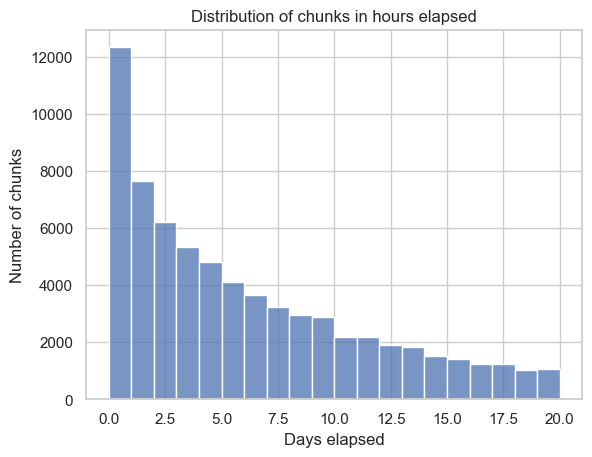

In [24]:
# print distribution of chunks in hours elapsed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# plot number of chunks in time buckets of 12 hours
# limit range to 0-24*20 hours
hours_elapsed_list_filt = [np.array(x)/24 for x in hours_elapsed_list]
hours_elapsed_list_filt = [x[x<20] for x in hours_elapsed_list_filt]
sns.histplot(np.concatenate(hours_elapsed_list_filt), bins = 20)
plt.xlabel("Days elapsed")
plt.ylabel("Number of chunks")
plt.title("Distribution of chunks in hours elapsed")


Try new experiment set up: select always first and last note, randomly sample in between

In [104]:
np.random.seed(1)
def filter_mask(seq_ids):
    first_note = seq_ids[0]
    first_indices = np.where(np.array(seq_ids) == seq_ids[0])[0]
    # limit DS to 4 chunks
    last_indices = np.where(np.array(seq_ids) == seq_ids[-1])[0][-4:]
    middle_indices = np.where(np.logical_and(np.array(seq_ids) > seq_ids[0], np.array(seq_ids) <  seq_ids[-1]))[0]
    middle_indices = np.sort(
        np.random.choice(
            middle_indices,
            max(0,min(len(middle_indices), 8 - len(first_indices) - len(last_indices))),
            replace = False
        )
    )
    return first_indices.tolist() +  middle_indices.tolist() + last_indices.tolist()

In [106]:
filter_mask(seq_ids_list[3])

[0, 55, 101, 122, 158, 159, 160, 161]

In [124]:
print(notes_agg_df.iloc[4]["CATEGORY"][-3])


Radiology


In [123]:
# TODO: I found that for some patients the DS is not the last note
# TODO: moreover, sometimes there are 2 DS, and the last one is void
print(notes_agg_df.iloc[4]["TEXT"][-2])
print(notes_agg_df.iloc[4]["ICD9_CODE_BINARY"])

Admission Date:  [**2132-12-31**]              Discharge Date:   [**2133-1-27**]

Date of Birth:  [**2076-5-13**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 2186**]
Chief Complaint:
Progressive signs of dizziness, visual difficulties, unsteady
gait

Major Surgical or Invasive Procedure:
Right-sided high frontal stereotactic biopsy, CT-guided target
point, definition and MRI-guided intraoperative imaging.


History of Present Illness:
The patient is a 56-year-old male with a history of colon
cancer, as well as testicular cancer, who presents with
progressive signs of dizziness, visual difficulties, unsteady
gait for approximately 12 months. He was worked up including an
MRI scan that showed a brainstem lesion. He was referred to the
brain tumor clinic for consideration of a biopsy.

The patient has been followed at the [**Hospital6 **] at [**Location 10050**]. He had been treated for a number 

In [138]:
notes_agg_df_filt = notes_agg_df.copy()
# Modify the TEXT, CHARTDATE, CHARTTIME, CATEGORY columns
# by limiting the list to include all elements until the first DS
# the apply function is used to apply the lambda function to each row
# and it should filter based on the CATEGORY column
notes_agg_df_filt["TEXT"] = notes_agg_df_filt[["TEXT", "CATEGORY"]].apply(
    lambda x: x.TEXT[:x.CATEGORY.index("Discharge summary")+1],
    axis = 1
)
notes_agg_df_filt["CHARTDATE"] = notes_agg_df_filt[["CHARTDATE", "CATEGORY"]].apply(
    lambda x: x.CHARTDATE[:x.CATEGORY.index("Discharge summary")+1],
    axis = 1
)
notes_agg_df_filt["CHARTTIME"] = notes_agg_df_filt[["CHARTTIME", "CATEGORY"]].apply(
    lambda x: x.CHARTTIME[:x.CATEGORY.index("Discharge summary")+1],
    axis = 1
)
notes_agg_df_filt["CATEGORY"] = notes_agg_df_filt["CATEGORY"].apply(
    lambda x: x[:x.index("Discharge summary")+1]
)


In [ ]:
# TODO: investigate if the notes that are not DS are important

In [139]:
num = 0
for i in range(len(notes_agg_df)):
    if notes_agg_df.iloc[i]["CATEGORY"][-1] != "Discharge summary":
        num += 1
print(num)

1405


In [140]:
num = 0
for i in range(len(notes_agg_df_filt)):
    if notes_agg_df_filt.iloc[i]["CATEGORY"][-1] != "Discharge summary":
        num += 1
print(num)

0


In [115]:
notes_agg_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'TEXT', 'CHARTDATE', 'CHARTTIME', 'CATEGORY',
       'SPLIT_50', 'absolute_code', 'CATEGORY_INDEX', 'CATEGORY_REVERSE_SEQID',
       'ADMISSION_DATETIME', 'TIME_ELAPSED', 'PERCENT_ELAPSED',
       'HOURS_ELAPSED', 'ICD9_CODE_BINARY', 'SPLIT'],
      dtype='object')

In [116]:
print(notes_agg_df.iloc[3]["absolute_code"])

['608.83', '038.9', '995.92', '584.9', '428.0', '427.31', '998.2', '997.4', '560.1', '608.4', 'E870.8', '414.00', 'V45.81', '62.3', '31.1', '61.3', '43.19', '96.6', '96.72', '33.23', '38.93']


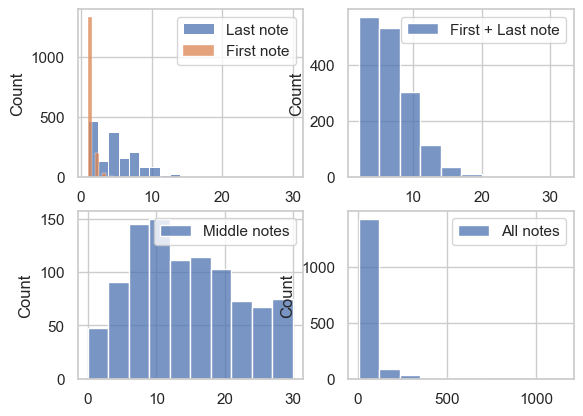

In [86]:
plt.subplot(2,2,1)
# print distribution of number of chunks of last note
sns.histplot([np.sum(np.array(seq_ids) == seq_ids[-1]) for seq_ids in seq_ids_list], bins = 20, label = "Last note")
# print distribution of number of chunks of first note
sns.histplot([np.sum(np.array(seq_ids) == seq_ids[0]) for seq_ids in seq_ids_list], bins = 20, label = "First note")
# print distribution of the sum of number of chunks of last and first note
plt.legend()
plt.subplot(2,2,2)
sns.histplot([np.sum(np.array(seq_ids) == seq_ids[0]) + np.sum(np.array(seq_ids) == seq_ids[-1]) for seq_ids in seq_ids_list], bins = 10, label = "First + Last note")
plt.legend()
plt.subplot(2,2,3)
# print distribution of number of chunks that are not first or last note
sns.histplot([np.sum(np.logical_and(np.array(seq_ids) > seq_ids[0], np.array(seq_ids) < seq_ids[-1]) )for seq_ids in seq_ids_list], bins = 10, label = "Middle notes", binrange=(0, 30))
plt.legend()
plt.subplot(2,2,4)
# print distribution of ALL notes
sns.histplot([len(seq_ids) for seq_ids in seq_ids_list], bins = 10, label = "All notes")
plt.legend()


In [ ]:
# Plot distribution when selecting last 16 chunks
plt.subplot(2,2,1)


In [ ]:
# print distribution of number of chunks of 

# Analyze sequence in both setups

In [1]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse

def boolean_string(s):
    if s not in {'False', 'True'}:
        raise ValueError('Not a valid boolean string')
    return s == 'True'

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# device
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')
print(device)

### for debugging use cpu
#device = cpu

config = {
#    "run_name": "Run_test_TLWAN"
    "run_name": "viz"
    ,"project_path": '/vol/bitbucket/mh1022/temporal-modelling-icd'
    ,"base_checkpoint": os.path.join("", "RoBERTa-base-PM-M3-Voc-hf")
    ,"num_attention_heads": 1
    ,"num_layers": 1
    ,"lr": 5e-5
    ,"max_chunks": 16
    ,"grad_accumulation": 4
    ,"use_positional_embeddings": True
    ,"use_reverse_positional_embeddings": True
    ,"priority_mode": "None"
    ,"priority_idxs": [1]
    ,"use_document_embeddings": True
    ,"use_reverse_document_embeddings": True
    ,"use_category_embeddings": True
    ,"num_labels": 50
    ,"use_all_tokens": True
    ,"num_heads_labattn":1
    ,"final_aggregation": "cls"
    ,"only_discharge_summary": False
    ,"patience_threshold": 3
    ,"max_epochs": 3
    ,"save_model": False
    ,"load_from_checkpoint": False
    ,"checkpoint_name": "Run_all_notes_last_second_transf"
    ,"evaluate_temporal": False
    ,"use_multihead_attention": False
    ,"debug": False
}
with open(os.path.join("", f"results/config_{config['run_name']}.json"), "w") as f:
    json.dump(config, f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)


/vol/bitbucket/mh1022/dl_cw_pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


In [2]:
notes_agg_df, categories_mapping = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
from data.utils import get_dataset, get_tokenizer, get_dataloader
# Get training / validation / test
dataset_config = {
    "max_chunks" : config["max_chunks"],
    "setup": "uniform"
}

validation_set =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)
dataset_config = {
    "max_chunks" : config["max_chunks"],
    "setup": "latest"
}
validation_set_latest =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)


In [23]:
sample = validation_set[45]

In [25]:
sample = validation_set[12]
sample["cutoffs"]

{'2d': 0, '5d': 0, '13d': 2, 'noDS': 4, 'all': -1}

In [34]:
sample = validation_set_latest[12]
sample["cutoffs"]

{'2d': 4, '5d': 4, '13d': 4, 'noDS': 4, 'all': -1}

In [29]:
hours_elapsed = sample["hours_elapsed"]
len(hours_elapsed)

548

In [31]:
input_ids = sample["input_ids"]
input_ids.shape

torch.Size([16, 512])

In [33]:
category_ids = sample["category_ids"]
category_ids.shape

torch.Size([16])

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# get number of chunks in each time range
def get_temporal_dist(validation_set):
    notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
    num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

    for i in range(len(validation_set)):
        sample = validation_set[i]
        cutoffs =sample["cutoffs"]
        for time_range in ["2d","5d","13d","noDS"]:
            if cutoffs[time_range] != -1:
                notes_length[time_range].append(cutoffs[time_range]+1)
                num_samples[time_range].append(1)
        notes_length["all"].append(len(sample["seq_ids"]))
        num_samples["all"].append(1)
    return notes_length, num_samples

def plot_temporal_dist(notes_length, num_samples):
    # print bar plot with the average number of notes and number of samples in each time range

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 10))
    plt.bar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()])
    # show the standard deviation on the bar plot
    # show the average number of notes in each time range on top of the bar plot as a number
    for i, time_range in enumerate(notes_length.keys()):
        plt.text(i, np.mean(notes_length[time_range]), f"{np.mean(notes_length[time_range]):.2f}", ha='center', va='bottom')
    plt.errorbar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()], yerr=[np.std(notes_length[key]) for key in notes_length.keys()], fmt='none', c='black', label='std')
    # show the median number of notes in each time range as a line on the bar plot
    plt.plot(notes_length.keys(), [np.median(notes_length[key]) for key in notes_length.keys()], c='red', label='median')
    # show median number of notes on top of the bar plot as a number
    for i, time_range in enumerate(notes_length.keys()):
        plt.text(i, np.median(notes_length[time_range]), f"{np.median(notes_length[time_range]):.2f}", ha='center', va='bottom', c='red')
    # add another bar plot with the number of samples
    # the bar plot needs to be separated from the previous one
    # otherwise the y-axis will be shared and the number of samples will be too small to be seen
    plt.title('Average number of notes in each time range')
    plt.xlabel('Time range')
    plt.ylabel('Number of notes')
    plt.legend()
    plt.figure(figsize=(10, 10))

    plt.bar(notes_length.keys(), [np.sum(num_samples[key]) for key in notes_length.keys()])
    # show number of samples on top of the bar plot as a number
    for i, time_range in enumerate(notes_length.keys()):
        plt.text(i, np.sum(num_samples[time_range]), f"{np.sum(num_samples[time_range]):.0f}", ha='center', va='bottom')
    plt.title('Total number of notes in each time range')
    plt.show()




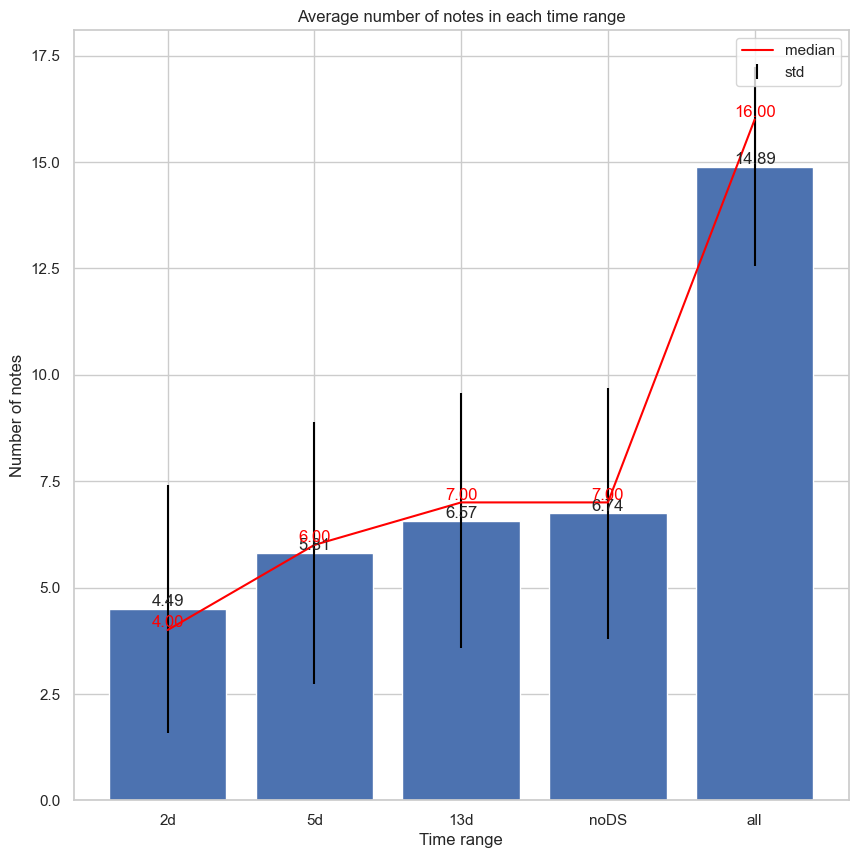

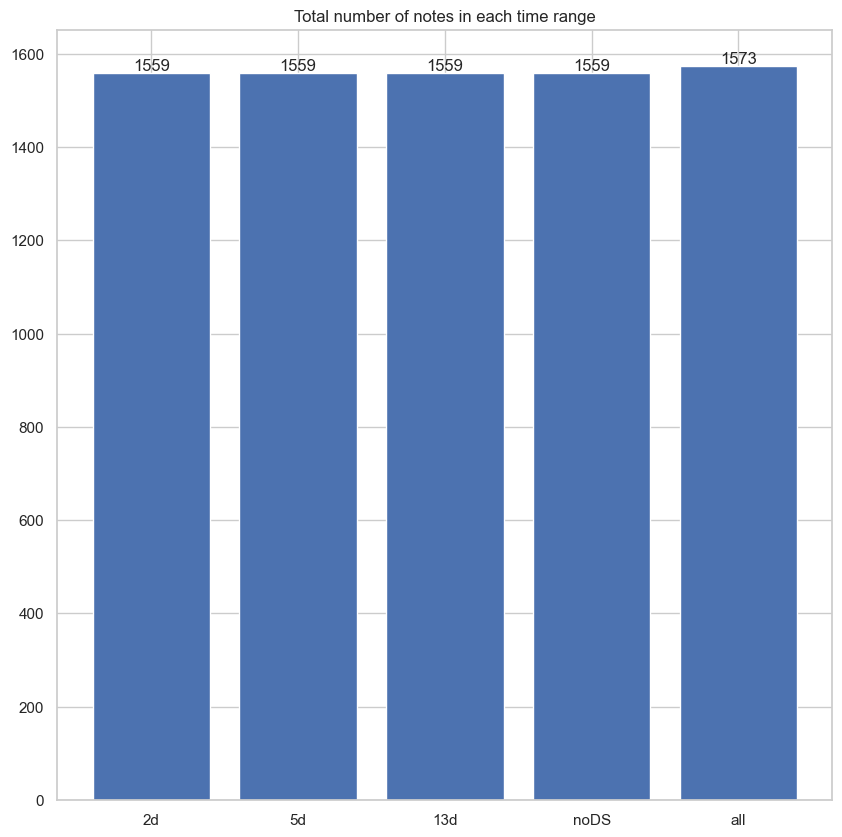

In [42]:
notes_length, num_samples = get_temporal_dist(validation_set)
plot_temporal_dist(notes_length, num_samples)

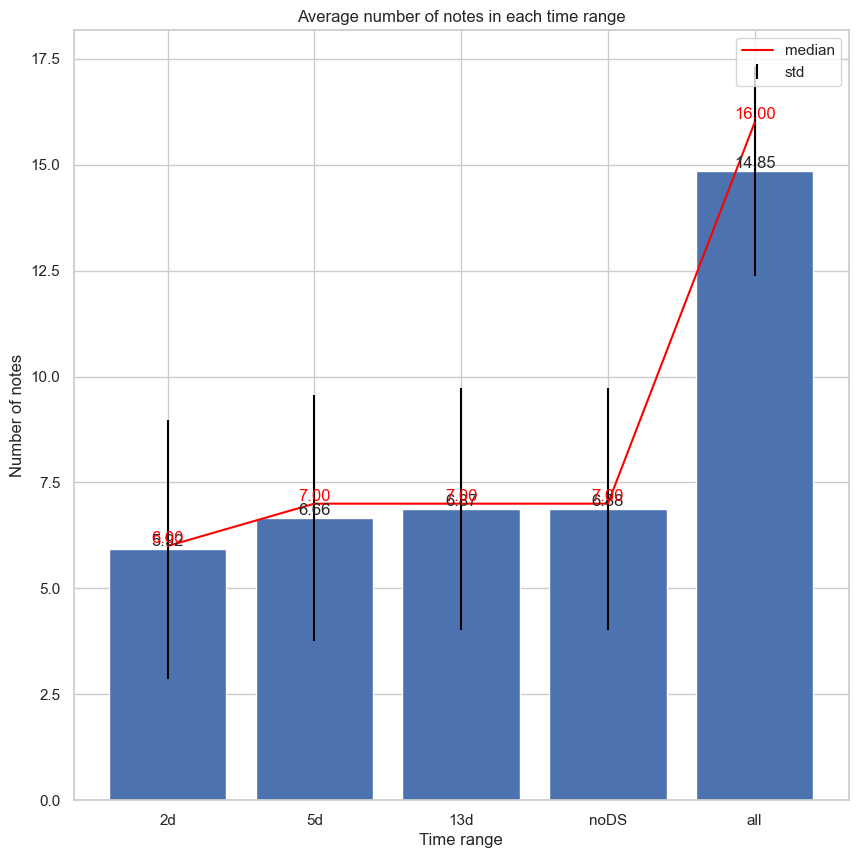

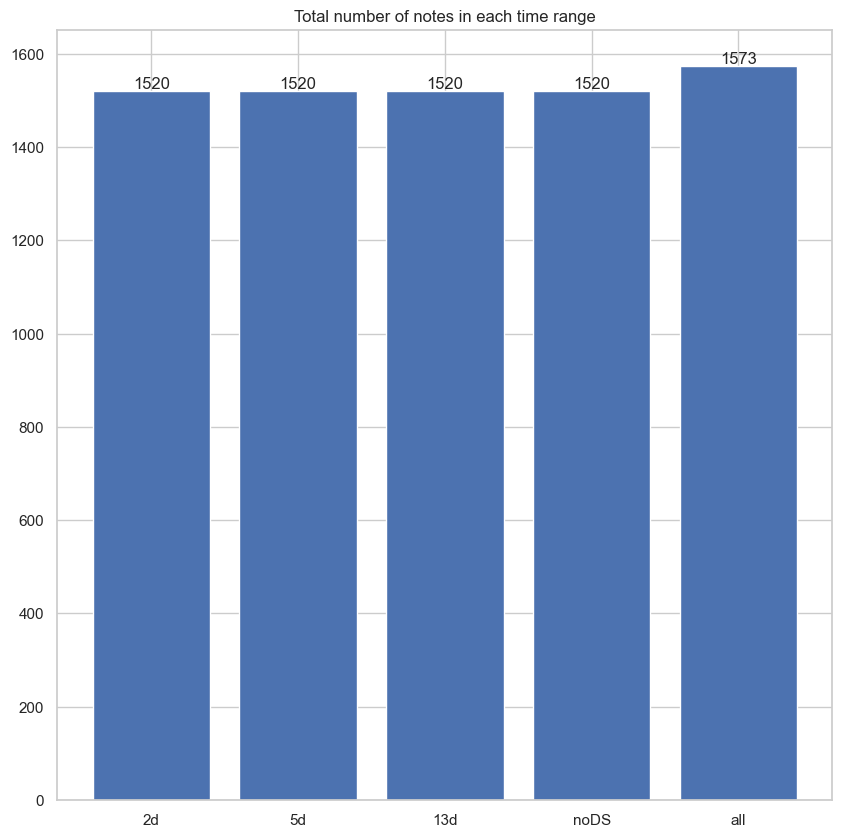

In [43]:
notes_length_latest, num_samples_latest = get_temporal_dist(validation_set_latest)
plot_temporal_dist(notes_length_latest, num_samples_latest)

#### Analyze sections of DS

#### Analyze number of notes in each time range

In [ ]:
def get_cutoffs(hours_elapsed, category_ids):
    cutoffs = {'2d': -1, '5d': -1, '13d': -1, 'noDS': -1, 'all': -1}
    for i, (hour, cat) in enumerate(zip(hours_elapsed, category_ids)):
        if cat != 5:
            if hour < 2*24:
                cutoffs['2d'] = i
            if hour < 5*24:
                cutoffs['5d'] = i
            if hour < 13*24:
                cutoffs['13d'] = i
            cutoffs['noDS'] = i
        cutoffs['all'] = i
    return cutoffs

In [ ]:
# TODO: run this cell for the meeting - get the number of chunks in each time range for the validation set
# Get number of chunks in each time range for the validation set
cutoffs_stats = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

for i in range(len(validation_set)):
    sample = validation_set[i]
    cutoffs = get_cutoffs(sample['hours_elapsed'], sample['category_ids']) 
    for time_range in cutoffs_stats.keys():
        cutoffs_stats[time_range].append(cutoffs[time_range])

# Plot the average number of chunks for each time range
import matplotlib.pyplot as plt
plt.bar(cutoffs_stats.keys(), [np.mean(cutoffs_stats[time_range]) for time_range in cutoffs_stats.keys()])
plt.show()

In [24]:
def get_cutoffs(hours_elapsed, category_ids):
    cutoffs = {'2d': -1, '5d': -1, '13d': -1, 'noDS': -1, 'all': -1}
    for i, (hour, cat) in enumerate(zip(hours_elapsed, category_ids)):
        if cat != 5:
            if hour < 2*24:
                cutoffs['2d'] = i
            if hour < 5*24:
                cutoffs['5d'] = i
            if hour < 13*24:
                cutoffs['13d'] = i
            cutoffs['noDS'] = i
        cutoffs['all'] = i
    return cutoffs

In [25]:
from tqdm import tqdm
notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

for i in range(len(training_set)):
    sample = training_set[i]
    cutoffs = get_cutoffs(sample['hours_elapsed'], sample['category_ids'])
    for time_range in cutoffs.keys():
        if cutoffs != -1:
            notes_length[time_range].append(cutoffs[time_range])
            num_samples[time_range].append(1)


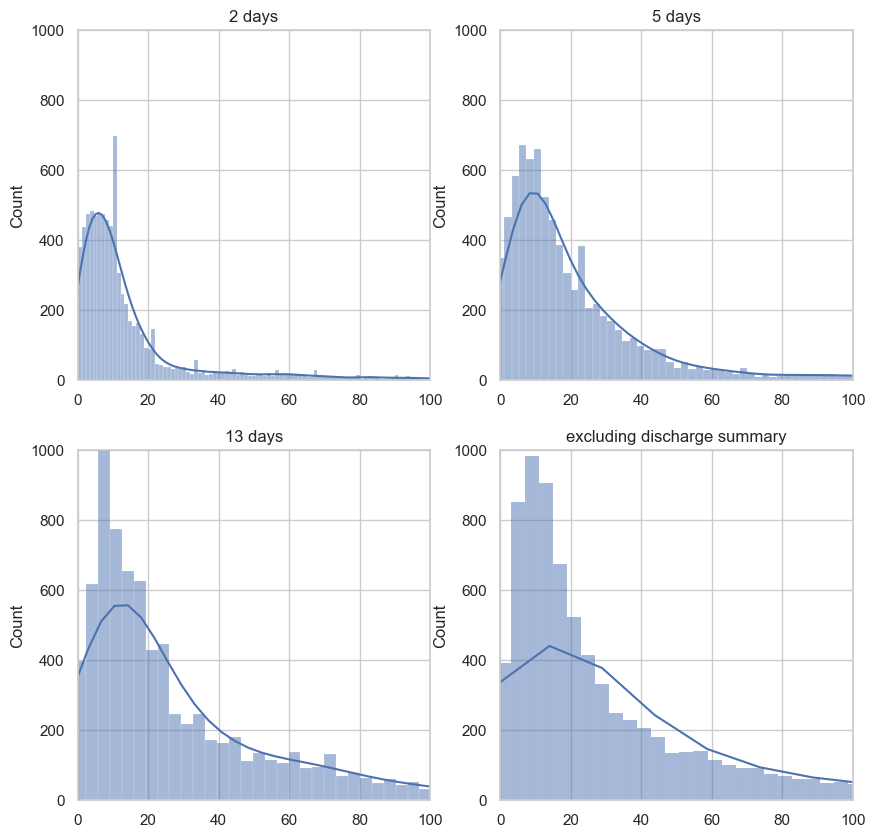

In [43]:
# plot the distribution of notes length for each time range
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(notes_length['2d'], ax=axs[0, 0], kde=True)
axs[0, 0].set_title('2 days')
# limit x-axis range from 0 to 1000
axs[0, 0].set_xlim([0, 100])
axs[0,0].set_ylim([0, 1000])
sns.histplot(notes_length['5d'], ax=axs[0, 1], kde=True)
axs[0, 1].set_title('5 days')
axs[0, 1].set_xlim([0, 100])
axs[0,1].set_ylim([0, 1000])

sns.histplot(notes_length['13d'], ax=axs[1, 0], kde=True)
axs[1, 0].set_title('13 days')
axs[1, 0].set_xlim([0, 100])
axs[1,0].set_ylim([0, 1000])

sns.histplot(notes_length['noDS'], ax=axs[1, 1], kde=True)
axs[1, 1].set_title('excluding discharge summary')
axs[1, 1].set_xlim([0, 100])
axs[1,1].set_ylim([0, 1000])

plt.show()


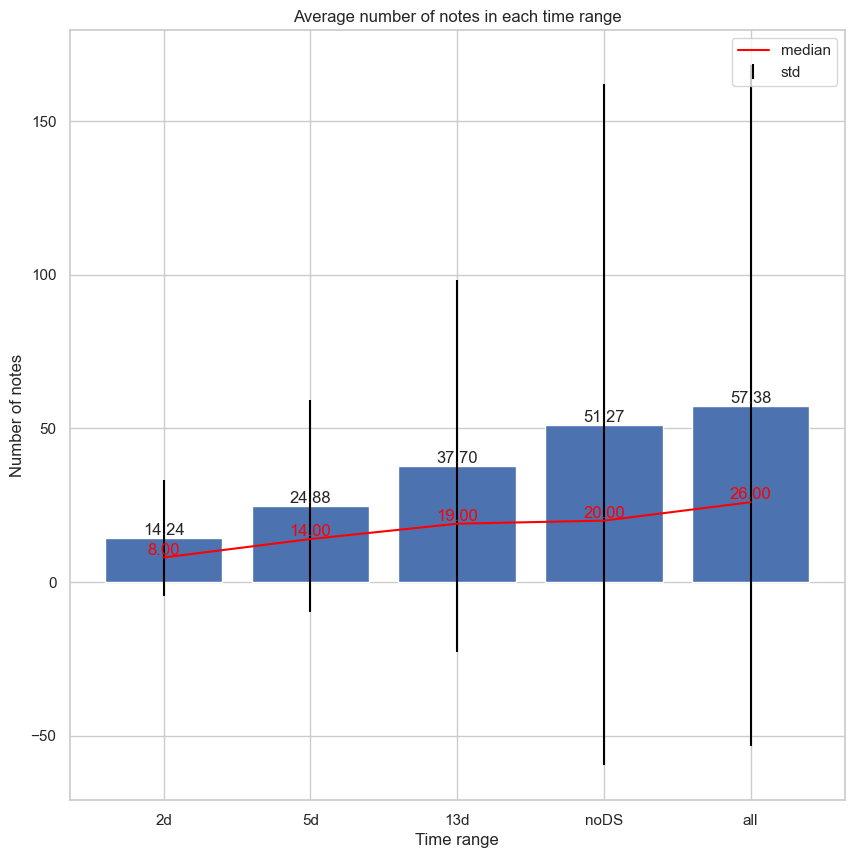

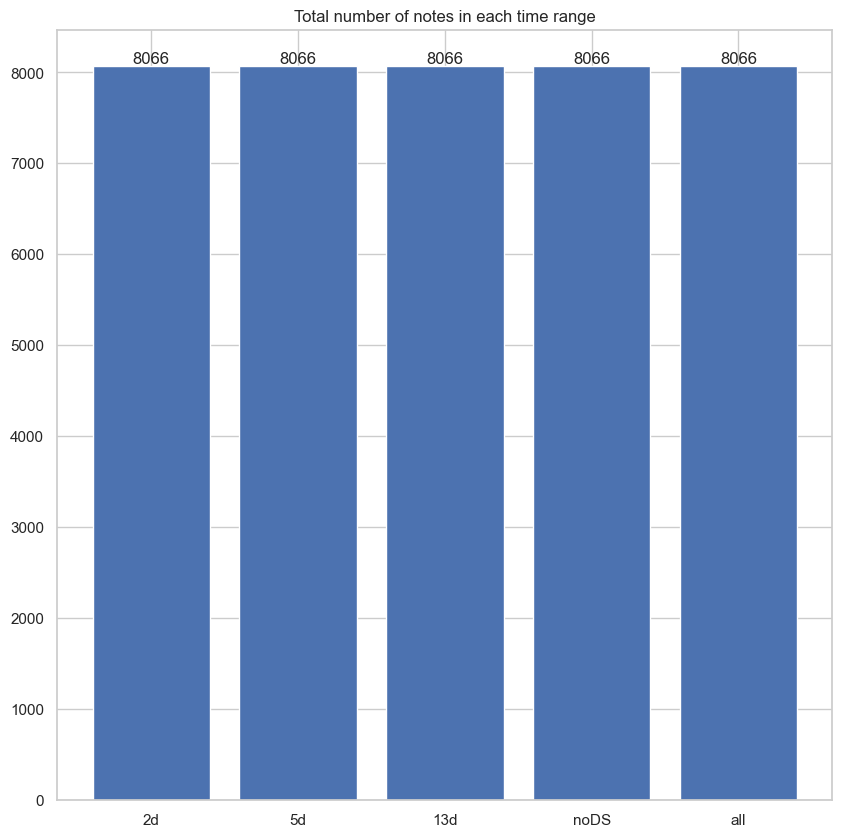

In [57]:
# print bar plot with the average number of notes and number of samples in each time range
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 10))
plt.bar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()])
# show the standard deviation on the bar plot
# show the average number of notes in each time range on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.mean(notes_length[time_range]), f"{np.mean(notes_length[time_range]):.2f}", ha='center', va='bottom')
plt.errorbar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()], yerr=[np.std(notes_length[key]) for key in notes_length.keys()], fmt='none', c='black', label='std')
# show the median number of notes in each time range as a line on the bar plot
plt.plot(notes_length.keys(), [np.median(notes_length[key]) for key in notes_length.keys()], c='red', label='median')
# show median number of notes on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.median(notes_length[time_range]), f"{np.median(notes_length[time_range]):.2f}", ha='center', va='bottom', c='red')
# add another bar plot with the number of samples
# the bar plot needs to be separated from the previous one
# otherwise the y-axis will be shared and the number of samples will be too small to be seen
plt.title('Average number of notes in each time range')
plt.xlabel('Time range')
plt.ylabel('Number of notes')
plt.legend()
plt.figure(figsize=(10, 10))

plt.bar(notes_length.keys(), [np.sum(num_samples[key]) for key in notes_length.keys()])
# show number of samples on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.sum(num_samples[time_range]), f"{np.sum(num_samples[time_range]):.0f}", ha='center', va='bottom')
plt.title('Total number of notes in each time range')
plt.show()


Average total duration: 11.35 days
Std total duration: 12.98 days
Min total duration: 0.00 days
Max total duration: 192.00 days


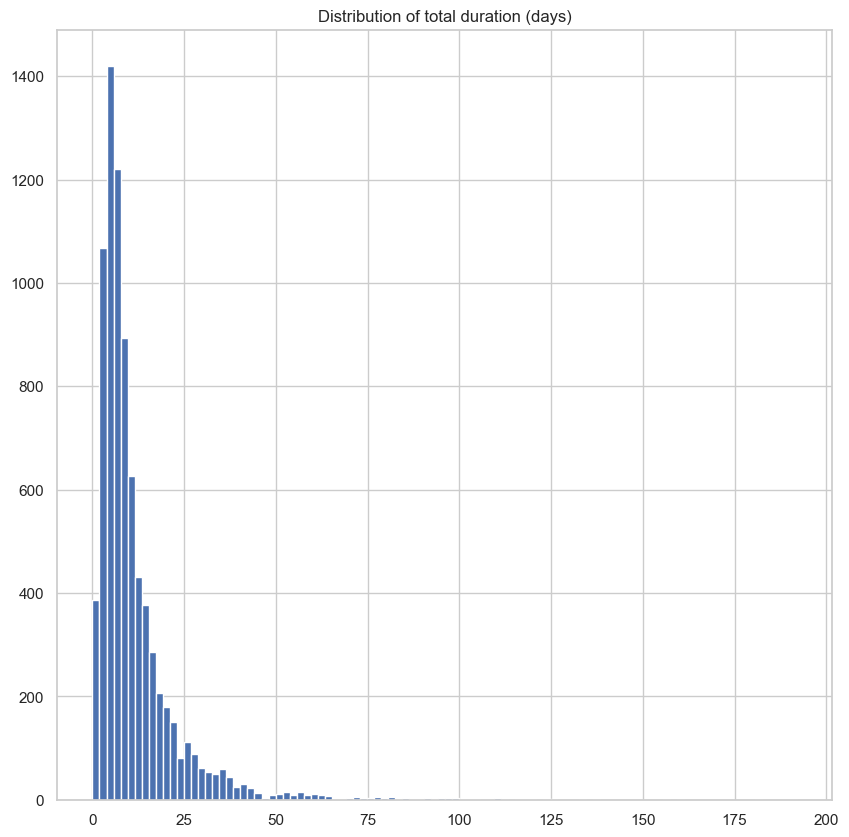

In [41]:
# show the shortest and longest stay
# by looking at hours_elapsed[-1]
# and the number of notes in each time range
total_duration = []
for i in range(len(training_set)):
    sample = training_set[i]
    total_duration.append(sample['hours_elapsed'][-1])
# show the average, std, min, max of the total duration
# in days
print(f"Average total duration: {np.mean(total_duration)/24:.2f} days")
print(f"Std total duration: {np.std(total_duration)/24:.2f} days")
print(f"Min total duration: {np.min(total_duration)/24:.2f} days")
print(f"Max total duration: {np.max(total_duration)/24:.2f} days")

# plot the distribution of total duration
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist([d/24 for d in total_duration], bins=100)
plt.title('Distribution of total duration (days)')
plt.show()


25% percentile: 1.84
50% percentile: 5.68
75% percentile: 13.74


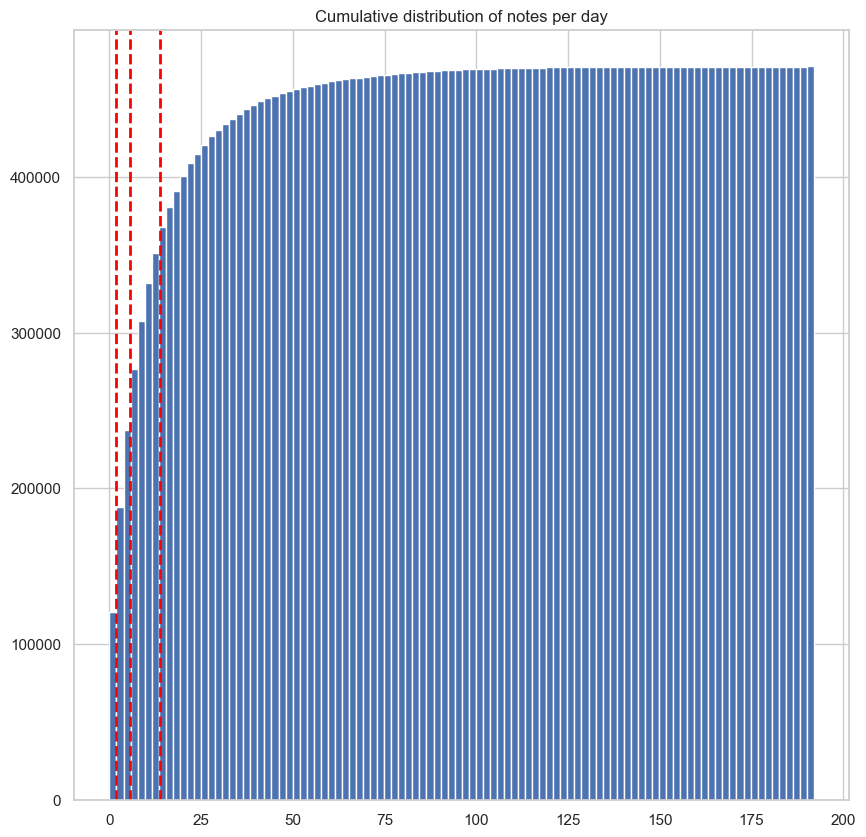

In [52]:
# show the numbr of notes under each time range
# in days
# show the shortest and longest stay
# by looking at hours_elapsed[-1]
# and the number of notes in each time range
notes_per_day = []
for i in range(len(training_set)):
    sample = training_set[i]
    notes_per_day.extend(sample['hours_elapsed']/24)

# show cumulative distribution of notes per day
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist(notes_per_day, bins=100, cumulative=True)
plt.title('Cumulative distribution of notes per day')

# show 25%, 50%, 75% percentile in the plot
plt.axvline(np.percentile(notes_per_day, 25), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(notes_per_day, 50), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(notes_per_day, 75), color='red', linestyle='dashed', linewidth=2)
# print the percentile as a number
print(f"25% percentile: {np.percentile(notes_per_day, 25):.2f}")
print(f"50% percentile: {np.percentile(notes_per_day, 50):.2f}")
print(f"75% percentile: {np.percentile(notes_per_day, 75):.2f}")
plt.show()


In [ ]:
from tqdm import tqdm
notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

num_chunks = 
for i in tqdm(range(len(training_set))):
    sample = training_set[i]
    hours_elapsed = sample["hours_elapsed"]
    seq_ids = sample["seq_ids"]
    for time_range in sample["cutoffs"].keys():
        if sample["cutoffs"][time_range] != -1:
            notes_length[time_range].append(sample['cutoffs'][time_range])
            num_samples[time_range].append(1)
